### HibriNet: A Hybrid Neural Network-based framework for Multi-Parametric Database Generation, Enhancement, and Forecasting

In this notebook, we introduce HybriNet — a hybrid, data-driven framework designed to enhance spatial resolution, generate fluid dynamics datasets for specific flow conditions, and predict their temporal evolution. The approach integrates High-Order Singular Value Decomposition (HOSVD) with advanced machine learning (ML) and deep learning (DL) techniques to construct an efficient Reduced-Order Model (ROM).

    This ROM framework enables:
    
    Generation of multi-parametric fluid dynamics databases under varying flow conditions.
    
    Super-resolution enhancement of low-resolution CFD data.
    
    Temporal forecasting of flow behavior.

By accelerating simulations and enabling efficient data synthesis, HybriNet offers a robust tool for fluid dynamics analysis. The framework is validated on a dataset of 30 two-dimensional laminar flow simulations over a square cylinder, varying in Reynolds numbers and angles of attack. The reconstructed high-resolution fields achieved a relative RMSE below 2%, demonstrating strong accuracy and generalization capability.



In [1]:
import numpy as np
import hosvd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from scipy.interpolate import interp1d
import random
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from sklearn.preprocessing import MinMaxScaler, StandardScaler

### Tensor Loading and Preparation
Loads the aligned high-dimensional tensor and selects the Reynolds and AoA dimensions for further analysis.

In [2]:
tensor = np.load("tensor_final_alineado1.npy")
tensor = tensor[:2,:,:, :, :, :] ##se añade la dimensión de reynolds y de aoa 

### Tensor Normalization
Centers and scales the tensor globally to ensure numerical stability and meaningful comparison across modes.

In [3]:
def center_scale_tensor(tensor, axes=(0,1,2,3,4,5), epsilon=1e-8):
    mean = np.mean(tensor, axis=axes, keepdims=True)
    std = np.std(tensor, axis=axes, keepdims=True)
    std = np.maximum(std, epsilon)
    return (tensor - mean) / std, mean, std

tensor, mean, std = center_scale_tensor(tensor)

### Define Reconstruction Function
Provides a utility to reverse normalization, converting scaled tensor values back to physical space.

In [4]:
def reconstruct_tensor(centered_scaled, mean, std):
    return centered_scaled * std + mean

### Define Target AoA and Reynolds Number
Defines the target angle of attack and Reynolds number to interpolate toward. The target values must lie within the existing label ranges.

In [5]:
aoa_labels = np.linspace(5, 30, 6)
# aoa_labels = np.delete(aoa_labels, 2)
desired_aoa = 22.5

re_labels = np.linspace(200, 280, 5)
# re_labels = np.delete(re_labels, 2)
desired_re = 230

### Compute Insertion Indices and Update Label Arrays
Finds appropriate indices for inserting the target AoA and Reynolds into the label arrays. Updates these arrays to reflect new interpolation points.

In [6]:
idx_below_aoa = np.searchsorted(aoa_labels, desired_aoa, side='right') - 1
idx_below_re = np.searchsorted(re_labels, desired_re, side='right') - 1

### Locate Desired Indices
Locates the new index positions of the inserted AoA and Reynolds values in the updated label arrays.

In [7]:
new_aoa_labels = np.insert(aoa_labels, idx_below_aoa+1, desired_aoa)
new_re_labels  = np.insert(re_labels,  idx_below_re+1,  desired_re)

desired_aoa_idx = np.where(new_aoa_labels == desired_aoa)[0][0]
desired_re_idx  = np.where(new_re_labels  == desired_re )[0][0]


### Perform HOSVD
Applies Higher-Order Singular Value Decomposition (HOSVD) to decompose the original tensor into core tensor and mode matrices using specified ranks.

In [8]:

# --- HOSVD ---
print('\nPerforming HOSVD. Please wait...\n')
hatT, S, U, sv, nn1 = hosvd.HOSVD_function(
    tensor, [tensor.shape[0], tensor.shape[1], 20, 20, tensor.shape[4], 7]
)


Performing HOSVD. Please wait...



### Plot Normalized Singular Values for Reynolds Mode
Plots log-scale decay of singular values for the Reynolds-number mode to analyze energy distribution across modes.

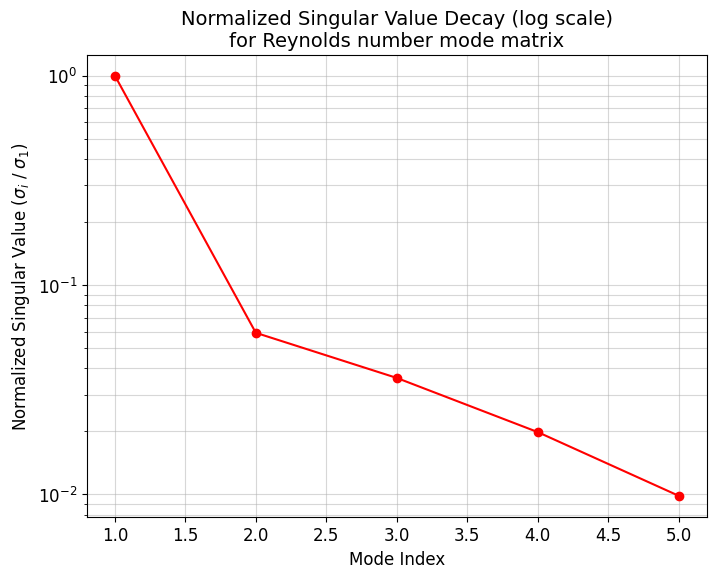

In [9]:

# Singular Value Decay for Reynolds-number mode matrix (normalized and log scale)
plt.figure(figsize=(8, 6))

normalized_sv = sv[0, 1] / sv[0, 1][0]

plt.semilogy(np.arange(1, len(normalized_sv) + 1), normalized_sv, 'o-', markersize=6, color='red')

plt.xlabel('Mode Index', fontsize=12)
plt.ylabel('Normalized Singular Value ($\sigma$$_i$ / $\sigma$$_1$)', fontsize=12)
plt.title('Normalized Singular Value Decay (log scale)\nfor Reynolds number mode matrix', fontsize=14)
plt.grid(True, which='both', alpha=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


### Plot Cumulative Energy for Reynolds Mode
Shows how much cumulative energy is captured by the first N modes in the Reynolds dimension.

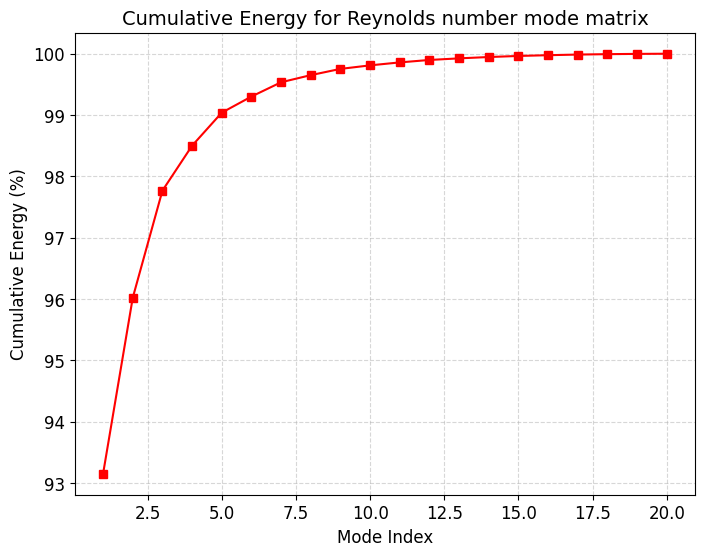

In [10]:
# Cumulative energy for Reynolds-number mode matrix
sv_sq = sv[0,3]**2
energy = 100 * np.cumsum(sv_sq) / np.sum(sv_sq)
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(energy) + 1), energy, 's-', color='red')
plt.xlabel('Mode Index', fontsize=12)
plt.ylabel('Cumulative Energy (%)', fontsize=12)
plt.title('Cumulative Energy for Reynolds number mode matrix', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


### Plot Normalized Singular Values for AoA Mode
Plots log-scale decay of singular values for the angle of attack mode.

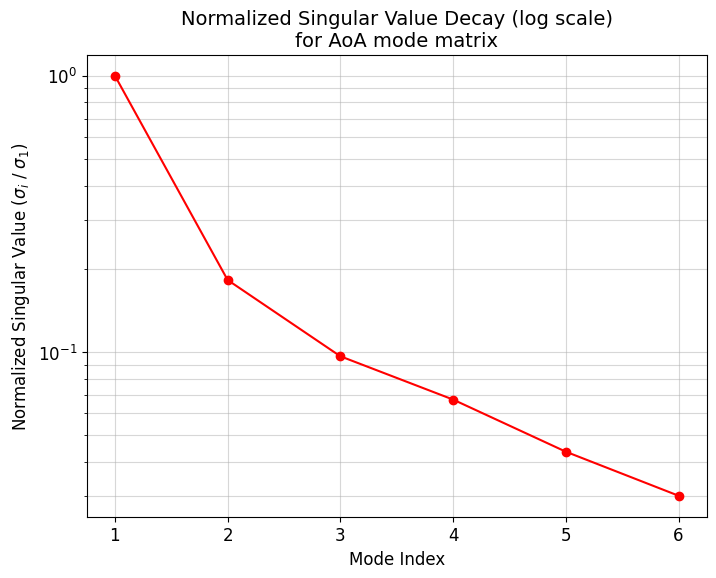

In [11]:
# Normalized Singular Value Decay for AoA mode matrix (log scale)
plt.figure(figsize=(8, 6))

normalized_sv_aoa = sv[0, 2] / sv[0, 2][0]
plt.semilogy(np.arange(1, len(normalized_sv_aoa) + 1), normalized_sv_aoa, 'o-', markersize=6, color='red')

plt.xlabel('Mode Index', fontsize=12)
plt.ylabel('Normalized Singular Value ($\sigma$$_i$ / $\sigma$$_1$)', fontsize=12)
plt.title('Normalized Singular Value Decay (log scale)\nfor AoA mode matrix', fontsize=14)
plt.grid(True, which='both', alpha=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()



### Plot Cumulative Energy for AoA Mode
Shows cumulative energy content across AoA modes.

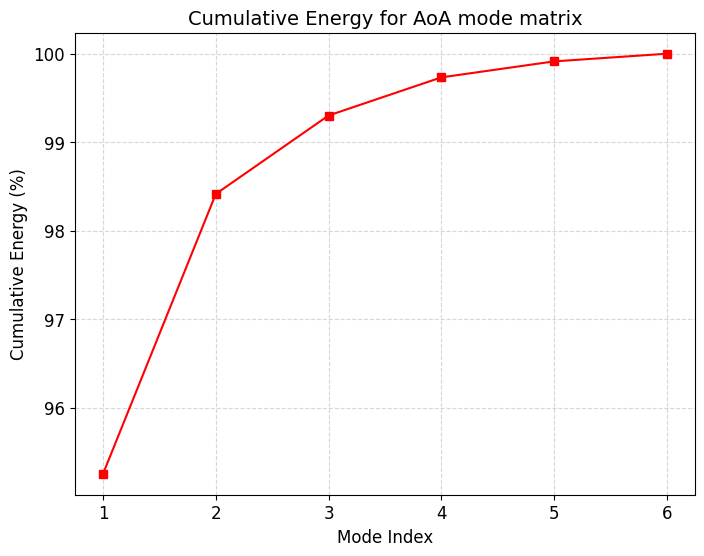

In [12]:
# Cumulative energy for AoA mode matrix
sv_sq = sv[0,2]**2
energy = 100 * np.cumsum(sv_sq) / np.sum(sv_sq)
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(energy) + 1), energy, 's-', color='red')
plt.xlabel('Mode Index', fontsize=12)
plt.ylabel('Cumulative Energy (%)', fontsize=12)
plt.title('Cumulative Energy for AoA mode matrix', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


### Plot Normalized Singular Values for Temporal Mode
Plots log-scale decay of singular values for the temporal (time) dimension.

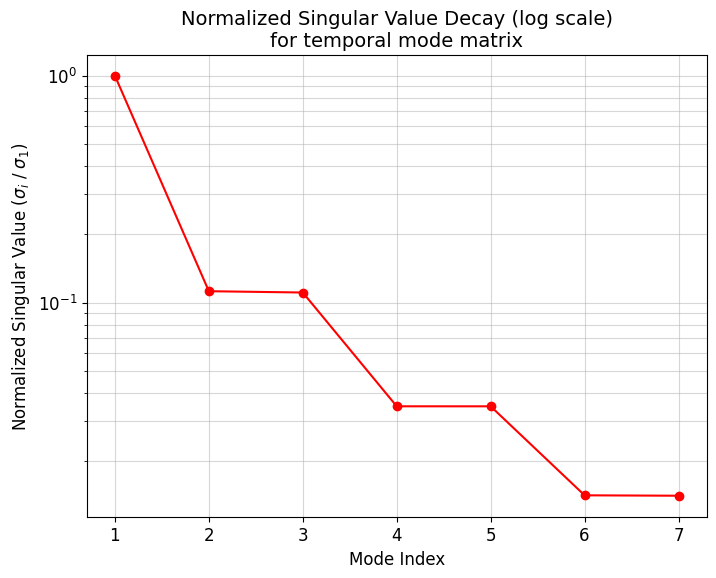

In [13]:

# Normalized Singular Value Decay for temporal mode matrix (log scale)
plt.figure(figsize=(8, 6))

normalized_sv_time = sv[0, 5] / sv[0, 5][0]
plt.semilogy(np.arange(1, len(normalized_sv_time) + 1), normalized_sv_time, 'o-', markersize=6, color='red')

plt.xlabel('Mode Index', fontsize=12)
plt.ylabel('Normalized Singular Value ($\sigma$$_i$ / $\sigma$$_1$)', fontsize=12)
plt.title('Normalized Singular Value Decay (log scale)\nfor temporal mode matrix', fontsize=14)
plt.grid(True, which='both', alpha=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


### Plot Cumulative Energy for Temporal Mode
Shows how many modes are required to capture most of the energy in the time domain.

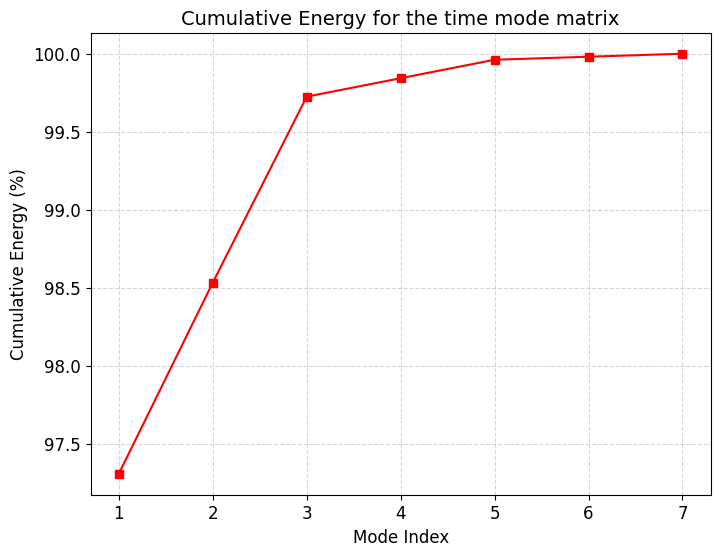

In [14]:
# Cumulative energy for time mode matrix
sv_sq = sv[0,5]**2
energy = 100 * np.cumsum(sv_sq) / np.sum(sv_sq)
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(energy) + 1), energy, 's-', color='red')
plt.xlabel('Mode Index', fontsize=12)
plt.ylabel('Cumulative Energy (%)', fontsize=12)
plt.title('Cumulative Energy for the time mode matrix', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### Plot Normalized Singular Values for Spatial X-Direction
Analyzes the decay of singular values in the x-direction spatial mode.

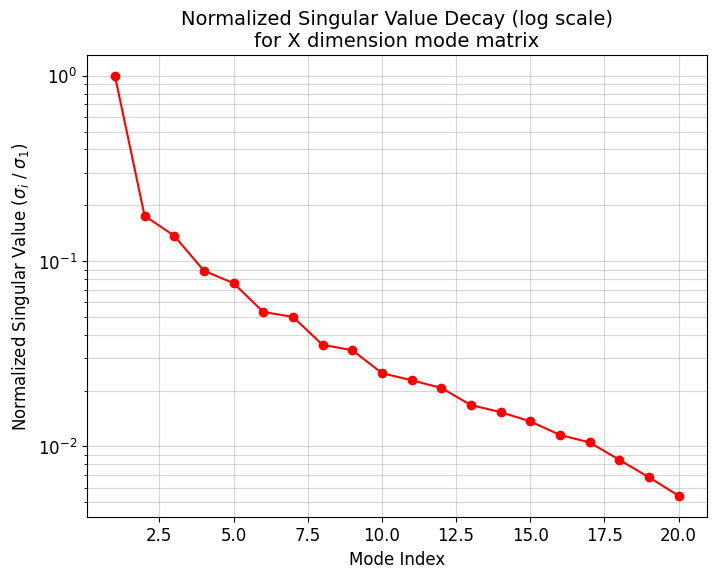

In [15]:
# Normalized Singular Value Decay for spatial X-direction mode matrix (log scale)
plt.figure(figsize=(8, 6))

normalized_sv_x = sv[0, 3] / sv[0, 3][0]

plt.semilogy(np.arange(1, len(normalized_sv_x) + 1), normalized_sv_x, 'o-', markersize=6, color='red')

plt.xlabel('Mode Index', fontsize=12)
plt.ylabel('Normalized Singular Value ($\sigma$$_i$ / $\sigma$$_1$)', fontsize=12)
plt.title('Normalized Singular Value Decay (log scale)\nfor X dimension mode matrix', fontsize=14)
plt.grid(True, which='both', alpha=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### Plot Normalized Singular Values for Spatial Y-Direction
Same as above, but for the y-direction spatial mode.

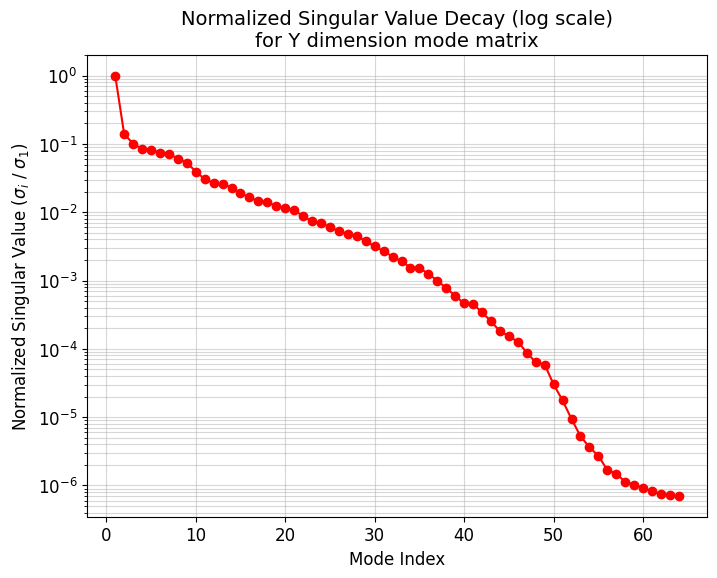

In [16]:
# Normalized Singular Value Decay for spatial Y-direction mode matrix (log scale)
plt.figure(figsize=(8, 6))

normalized_sv_y = sv[0, 4] / sv[0, 4][0]

plt.semilogy(np.arange(1, len(normalized_sv_y) + 1), normalized_sv_y, 'o-', markersize=6, color='red')

plt.xlabel('Mode Index', fontsize=12)
plt.ylabel('Normalized Singular Value ($\sigma$$_i$ / $\sigma$$_1$)', fontsize=12)
plt.title('Normalized Singular Value Decay (log scale)\nfor Y dimension mode matrix', fontsize=14)
plt.grid(True, which='both', alpha=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### Define QR-Based Re-Orthonormalization
Utility function to re-orthonormalize interpolated matrices and maintain numerical integrity.

In [17]:
def re_orthonormalize(mat):
    Q, R = np.linalg.qr(mat)
    return Q @ R

### Interpolate Reynolds Modes Using GPR
Interpolates the Reynolds mode matrix using Gaussian Process Regression (GPR) and linear fallback, then reconstructs the mode matrix.

C:\Users\guill\anaconda3\envs\modelflowscl\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\guill\anaconda3\envs\modelflowscl\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


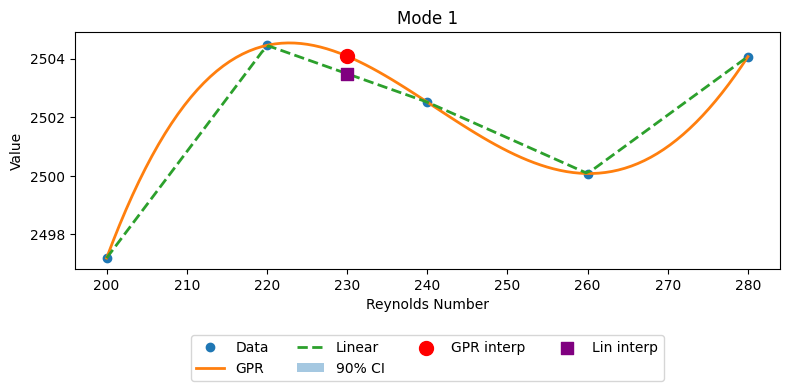

C:\Users\guill\anaconda3\envs\modelflowscl\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


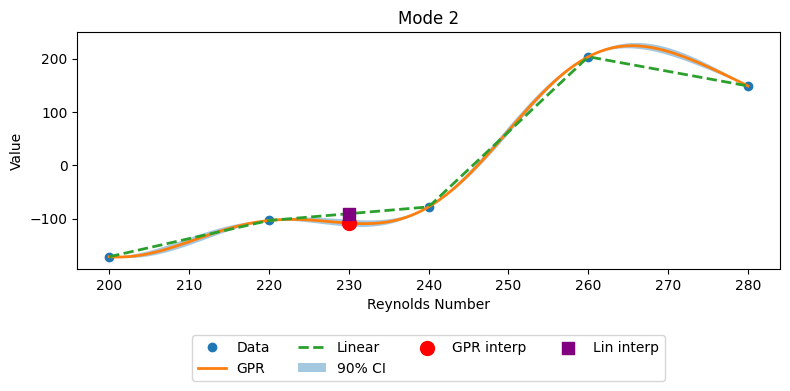

C:\Users\guill\anaconda3\envs\modelflowscl\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\guill\anaconda3\envs\modelflowscl\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


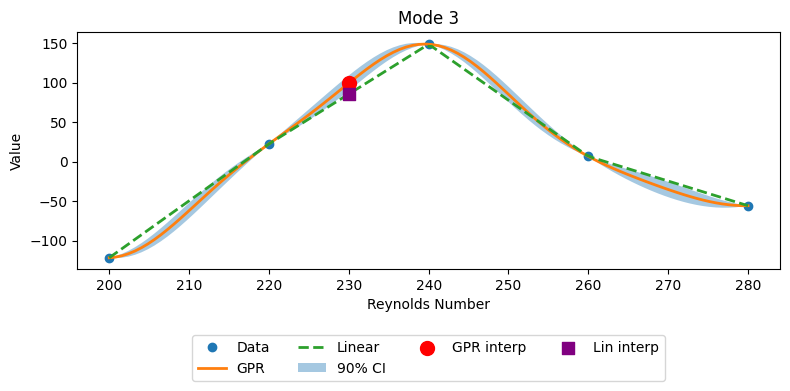

C:\Users\guill\anaconda3\envs\modelflowscl\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\guill\anaconda3\envs\modelflowscl\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


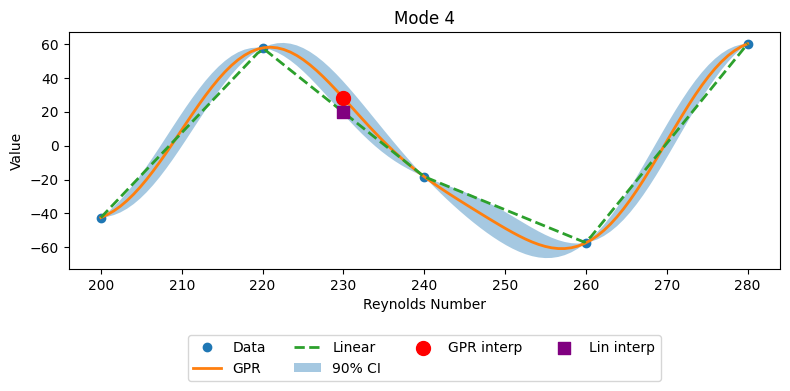

C:\Users\guill\anaconda3\envs\modelflowscl\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\guill\anaconda3\envs\modelflowscl\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


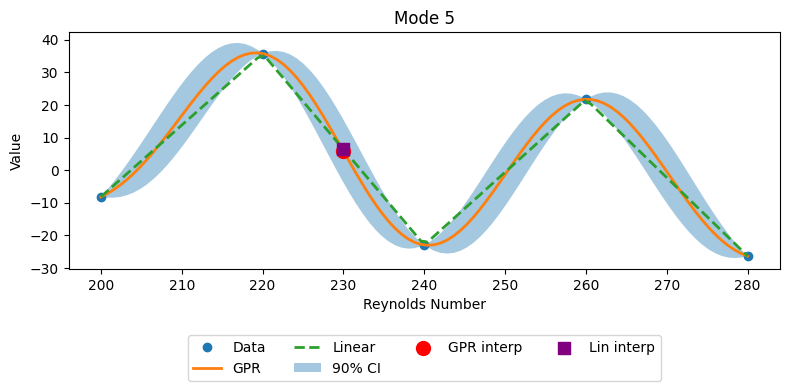

In [18]:
tol = 0 #tolerance if we want to mix the linear interpolation and GPR if set to 0 its only GPR

#interpolación en la dimensión de los número de Reynolds
s_U = U[0,1].copy()
m_mat = s_U * sv[0,1][:s_U.shape[1]]
m_mat = re_orthonormalize(m_mat)

x = re_labels.reshape(-1, 1)
kernel = C(1.0, (1e-2, 1e2)) * RBF(length_scale=50, length_scale_bounds=(10, 100))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20, alpha=1e-10)
x_fine = np.linspace(re_labels[0], re_labels[-1], 100).reshape(-1, 1)
x_interp = np.array([[desired_re]])
interp_lin = np.zeros(m_mat.shape[1])
interp_gpr = np.zeros(m_mat.shape[1])
interp_re = np.zeros(m_mat.shape[1])

for i in range(m_mat.shape[1]):
    y = m_mat[:, i]
    gp.fit(x, y)
    y_pred, sigma = gp.predict(x_fine, return_std=True)
    y_i, _ = gp.predict(x_interp, return_std=True)
    interp_gpr[i] = y_i[0]

    lin = interp1d(re_labels, y, kind='linear', fill_value='extrapolate')
    y_lin_fine = lin(x_fine.flatten())
    interp_lin[i] = lin(desired_re)
    interp_re[i] = (1 - tol) * interp_gpr[i] + tol * interp_lin[i]

    # Plot per mode
    plt.figure(figsize=(8, 4))
    plt.plot(x, y, 'o', markersize=6, label='Data')
    plt.plot(x_fine, y_pred, '-', linewidth=2, label='GPR')
    plt.plot(x_fine, y_lin_fine, '--', linewidth=2, label='Linear')
    plt.fill_between(x_fine.flatten(), y_pred - 1.645 * sigma, y_pred + 1.645 * sigma,
                     alpha=0.4, label='90% CI')
    plt.scatter(x_interp, y_i, color='red', s=100, zorder=3, label='GPR interp')
    plt.scatter(x_interp, interp_lin[i], color='purple', marker='s', s=80, zorder=4, label='Lin interp')
    plt.xlabel('Reynolds Number'); plt.ylabel('Value')
    plt.title(f'Mode {i + 1}')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=4, fontsize='medium')
    plt.subplots_adjust(bottom=0.3)
    plt.tight_layout()
    plt.show()

# Reconstruct
upper = m_mat[:idx_below_re+1]
lower = m_mat[idx_below_re+1:]
S_Unew = np.vstack((upper, interp_re, lower))
S_Unew = S_Unew / sv[0,1][:S_Unew.shape[1]]
S_Unew = re_orthonormalize(S_Unew)
U[0,1] = S_Unew


### Interpolate AoA Modes Using GPR
Same procedure as for Reynolds modes, now applied to angle of attack.

C:\Users\guill\anaconda3\envs\modelflowscl\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\guill\anaconda3\envs\modelflowscl\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


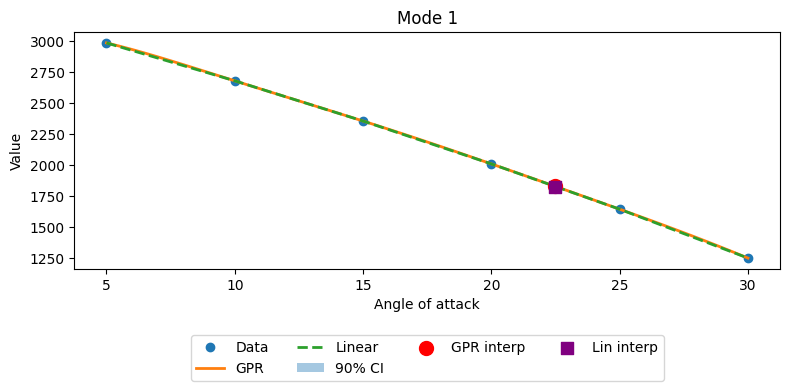

C:\Users\guill\anaconda3\envs\modelflowscl\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\guill\anaconda3\envs\modelflowscl\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


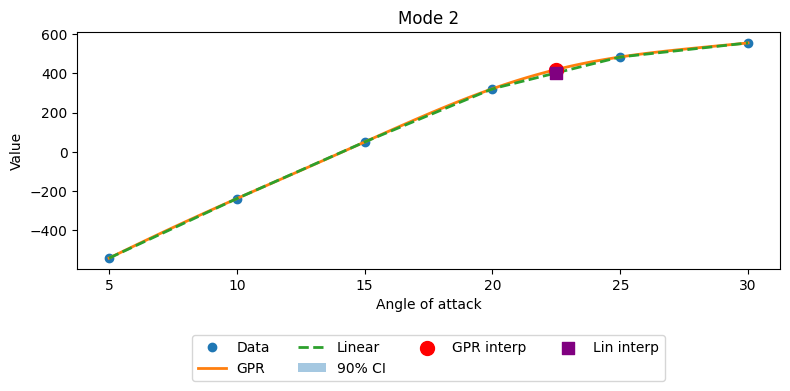

C:\Users\guill\anaconda3\envs\modelflowscl\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\guill\anaconda3\envs\modelflowscl\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


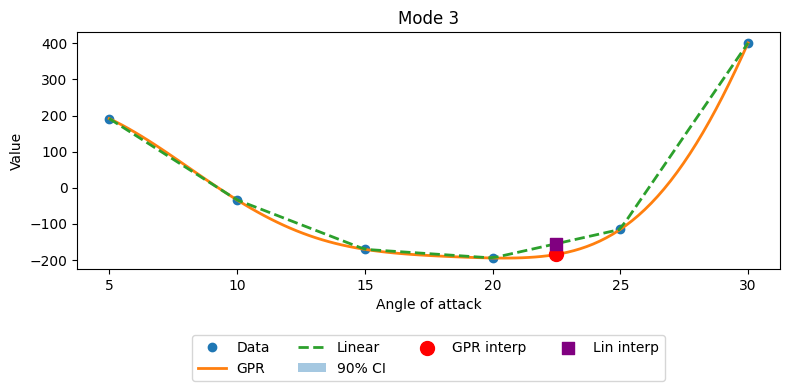

C:\Users\guill\anaconda3\envs\modelflowscl\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\guill\anaconda3\envs\modelflowscl\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


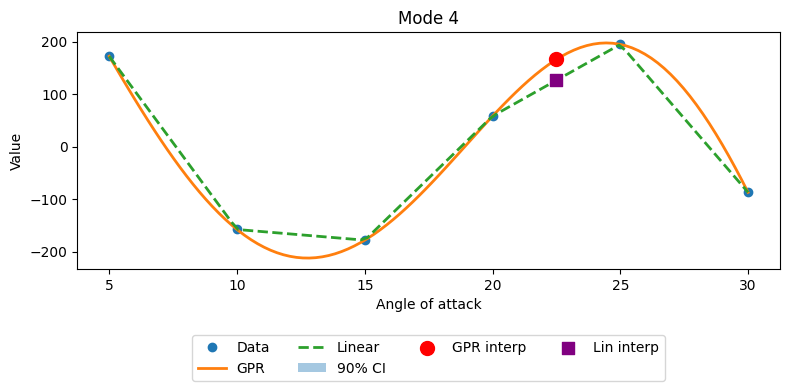

C:\Users\guill\anaconda3\envs\modelflowscl\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\guill\anaconda3\envs\modelflowscl\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


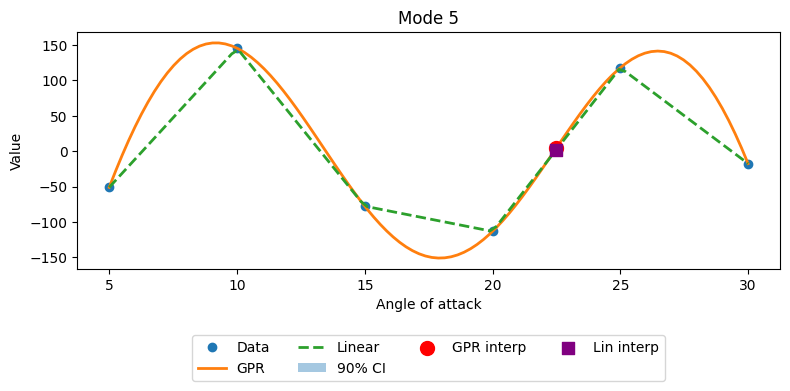

C:\Users\guill\anaconda3\envs\modelflowscl\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\guill\anaconda3\envs\modelflowscl\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


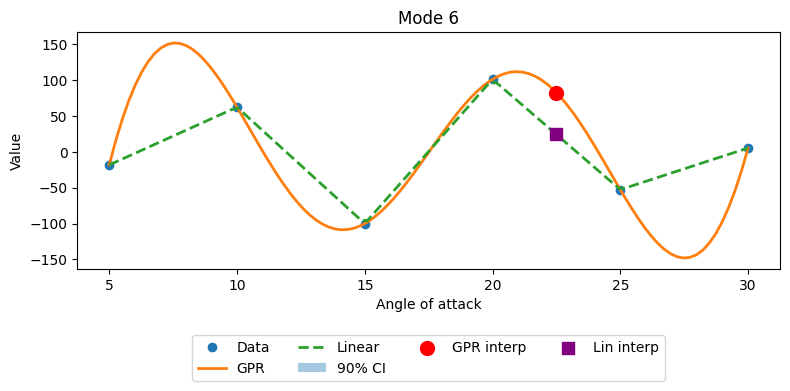

In [19]:
s_U1 = U[0,2].copy()
m_mat_aoa = s_U1 * sv[0,2][:s_U1.shape[1]]
m_mat_aoa = re_orthonormalize(m_mat_aoa)

x = aoa_labels.reshape(-1, 1)
kernel = C(1.0, (1e-2, 1e2)) * RBF(length_scale=50, length_scale_bounds=(10, 100))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20, alpha=1e-10)
x_fine = np.linspace(aoa_labels[0], aoa_labels[-1], 100).reshape(-1, 1)
x_interp = np.array([[desired_aoa]])
interp_lin = np.zeros(m_mat_aoa.shape[1])
interp_gpr = np.zeros(m_mat_aoa.shape[1])
interp_aoa = np.zeros(m_mat_aoa.shape[1])

for i in range(m_mat_aoa.shape[1]):
    y = m_mat_aoa[:, i]
    gp.fit(x, y)
    y_pred, sigma = gp.predict(x_fine, return_std=True)
    y_i, _ = gp.predict(x_interp, return_std=True)
    interp_gpr[i] = y_i[0]

    lin = interp1d(aoa_labels, y, kind='linear', fill_value='extrapolate')
    y_lin_fine = lin(x_fine.flatten())
    interp_lin[i] = lin(desired_aoa)
    interp_aoa[i] = (1 - tol) * interp_gpr[i] + tol * interp_lin[i]

    # Plot per mode
    plt.figure(figsize=(8, 4))
    plt.plot(x, y, 'o', markersize=6, label='Data')
    plt.plot(x_fine, y_pred, '-', linewidth=2, label='GPR')
    plt.plot(x_fine, y_lin_fine, '--', linewidth=2, label='Linear')
    plt.fill_between(x_fine.flatten(), y_pred - 1.645 * sigma, y_pred + 1.645 * sigma,
                     alpha=0.4, label='90% CI')
    plt.scatter(x_interp, y_i, color='red', s=100, zorder=3, label='GPR interp')
    plt.scatter(x_interp, interp_lin[i], color='purple', marker='s', s=80, zorder=4, label='Lin interp')
    plt.xlabel('Angle of attack'); plt.ylabel('Value')
    plt.title(f'Mode {i + 1}')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=4, fontsize='medium')
    plt.subplots_adjust(bottom=0.3)
    plt.tight_layout()
    plt.show()


upper = m_mat_aoa[:idx_below_aoa+1]
lower = m_mat_aoa[idx_below_aoa+1:]
S_Unew1 = np.vstack((upper, interp_aoa, lower))
S_Unew1 = S_Unew1 / sv[0,2][:S_Unew1.shape[1]]
S_Unew1 = re_orthonormalize(S_Unew1)
U[0,2] = S_Unew1

### Tensor Reconstruction from Interpolated Modes
Uses the interpolated mode matrices to reconstruct the full tensor, and extracts the specific sub-tensor for the desired conditions.

In [20]:
new_tensor_inter = hosvd.tprod(S, U)
new_tensor_inter = reconstruct_tensor(new_tensor_inter, mean, std)

interpolated_dataset_c = new_tensor_inter[:,desired_re_idx, desired_aoa_idx, :, :, :]

### Spatial Interpolation: Setup for GPR Upscaling
Prepares interpolation of spatial x/y mode matrices to higher resolution using GPR.

In [21]:
def train_gpr_from_low_res(U_low, N_high, alpha=1e-6, length_scale=0.05, nu=3):
    """
    U_low: [N_low, r] factor matrix
    N_high: desired number of rows
    """
    N_low, r = U_low.shape
    x_low  = np.linspace(0, 1, N_low).reshape(-1, 1)
    x_high = np.linspace(0, 1, N_high).reshape(-1, 1)

    U_high = np.zeros((N_high, r))
    kernel = C(1.0, constant_value_bounds="fixed") * Matern(length_scale=length_scale,
                                                            length_scale_bounds="fixed",
                                                            nu=nu)

    for i in range(r):
        y_low = U_low[:, i]
        gpr   = GaussianProcessRegressor(kernel=kernel, alpha=alpha,
                                          normalize_y=True, optimizer=None)
        gpr.fit(x_low, y_low)
        U_high[:, i] = gpr.predict(x_high)
    return U_high



### Apply Spatial Upscaling to X and Y Modes
Uses GPR to increase resolution of x and y mode matrices.

In [22]:
# Upscale U2 (x‑modes) and U3 (y‑modes)
N3_high = U[0,3].shape[0]*2
N4_high = U[0,4].shape[0]*2

U3_interp = train_gpr_from_low_res(U[0,3], N3_high)
U4_interp = train_gpr_from_low_res(U[0,4], N4_high)

U_list_interp = U.copy()
U[0,3] = U3_interp
U[0,4] = U4_interp


### Temporal Mode Normalization
Scales the temporal mode matrix using standard scaling to normalize across different dynamic ranges.

In [23]:

original_U5 = U[0, 5].copy()  
modes = range(original_U5.shape[1])
scalers = {}

U_scaled = original_U5.copy()

scaler = StandardScaler() 
U_scaled = scaler.fit_transform(U_scaled)

### Create Input-Output Sequences
Creates rolling window sequences of the normalized temporal mode matrix to use for time series forecasting.

In [24]:
def create_sequences(data, window_size, horizon):
    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size:i+window_size+horizon])
    return np.array(X), np.array(y)

window_size = 40
horizon = 1
seq, tar = create_sequences(U_scaled, window_size, horizon)


### Split Dataset Into Train/Val/Test
Splits the generated sequences into training, validation, and test datasets based on defined proportions.

In [25]:
n = len(seq)
i1 = int(0.7*n); i2 = int(0.85*n)
seq_train, seq_val, seq_test = seq[:i1], seq[i1:i2], seq[i2:]
tar_train, tar_val, tar_test = tar[:i1], tar[i1:i2], tar[i2:]

### PyTorch Dataset Class
Defines a custom Dataset class for PyTorch to handle sequence-based time series data.

In [26]:
class SequenceDataset(Dataset):
    def __init__(self, sequences, targets):
        self.X = torch.from_numpy(sequences).float()
        self.y = torch.from_numpy(targets).float()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = SequenceDataset(seq_train, tar_train)
val_ds   = SequenceDataset(seq_val, tar_val)
test_ds  = SequenceDataset(seq_test, tar_test)



### Dataloaders for Train, Val, Test
Creates PyTorch DataLoaders to iterate over the dataset in batches.

In [27]:
train_loader = DataLoader(train_ds, batch_size=1, shuffle=False)
val_loader   = DataLoader(val_ds, batch_size=1)
test_loader  = DataLoader(test_ds, batch_size=1)

### Define Forecasting LSTM Model
Constructs an LSTM-based model to forecast future temporal modes.

In [28]:

class TemporalForecasting(nn.Module):
    def __init__(self, input_size, hidden_size, output_window, output_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc   = nn.Linear(hidden_size, output_window * output_size)
        self.output_window = output_window
        self.output_size = output_size

    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        fc_out = self.fc(last)
        return fc_out.view(-1, self.output_window, self.output_size)


### Model Setup and Optimizer
Moves model to GPU/CPU, initializes the optimizer and loss function.

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TemporalForecasting(input_size=seq.shape[2], hidden_size=256, output_window=horizon, output_size=seq.shape[2]).to(device)
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=1e-4)

### Train LSTM with Early Stopping (Avoid this cell to upload the pretrained weights)
Trains the LSTM model on the temporal sequences using MSE loss and early stopping for stability.

In [30]:

patience = 20; best_val = float('inf'); epochs_no_improve = 0

for epoch in range(1, 600):
    model.train()
    train_losses = []
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(Xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    model.eval()
    val_losses = []
    with torch.no_grad():
        for Xv, yv in val_loader:
            Xv, yv = Xv.to(device), yv.to(device)
            val_losses.append(criterion(model(Xv), yv).item())

    avg_tr = np.mean(train_losses); avg_val = np.mean(val_losses)
    print(f"Epoch {epoch:03d} | Train MSE {avg_tr:.6f} | Val MSE {avg_val:.6f}")

    if avg_val < best_val:
        best_val = avg_val
        torch.save(model.state_dict(), "best_model.pt")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping.")
            break



Epoch 001 | Train MSE 0.990240 | Val MSE 0.919971
Epoch 002 | Train MSE 0.907517 | Val MSE 0.826132
Epoch 003 | Train MSE 0.794076 | Val MSE 0.639754
Epoch 004 | Train MSE 0.519915 | Val MSE 0.382670
Epoch 005 | Train MSE 0.309384 | Val MSE 0.477853
Epoch 006 | Train MSE 0.287678 | Val MSE 0.280492
Epoch 007 | Train MSE 0.197975 | Val MSE 0.206427
Epoch 008 | Train MSE 0.132004 | Val MSE 0.108749
Epoch 009 | Train MSE 0.103954 | Val MSE 0.290701
Epoch 010 | Train MSE 0.104458 | Val MSE 0.078176
Epoch 011 | Train MSE 0.068585 | Val MSE 0.126130
Epoch 012 | Train MSE 0.048100 | Val MSE 0.031446
Epoch 013 | Train MSE 0.034496 | Val MSE 0.104047
Epoch 014 | Train MSE 0.037183 | Val MSE 0.020808
Epoch 015 | Train MSE 0.028171 | Val MSE 0.078317
Epoch 016 | Train MSE 0.028134 | Val MSE 0.009048
Epoch 017 | Train MSE 0.020373 | Val MSE 0.072654
Epoch 018 | Train MSE 0.024748 | Val MSE 0.012921
Epoch 019 | Train MSE 0.015656 | Val MSE 0.040603
Epoch 020 | Train MSE 0.017511 | Val MSE 0.013386


### Forecast Temporal Modes
Uses the trained model to forecast future values of the temporal modes, using a rolling window autoregressive approach.

In [30]:
def predict_over_dataset(initial_sequence, model, window_size, horizon, num_iterations):
    last_seq = initial_sequence.copy()
    out = np.zeros((num_iterations * horizon, last_seq.shape[1]))
    idx = 0
    for _ in range(num_iterations):
        inp = torch.from_numpy(last_seq).float().unsqueeze(0).to(device)
        with torch.no_grad():
            p = model(inp).cpu().numpy().reshape(horizon, -1)
        out[idx:idx+horizon] = p
        idx += horizon
        last_seq = np.concatenate([last_seq[horizon:], p], axis=0)
    return out


### Import weights of the network
Imports the weights of the trained network (applicable if the user does not want to train in by himself due to computing resources).

In [31]:

model.load_state_dict(torch.load("best_model.pt"))
model.eval()

initial_test = seq_test[0]
over_matrix = predict_over_dataset(initial_test, model, window_size, horizon, num_iterations=100)


### Replace Temporal Mode with Forecasted One
Combines the predicted temporal mode back into the full mode matrix to reconstruct the forecasted tensor.

In [32]:

over_matrix = scaler.inverse_transform(over_matrix)

shape_temp = original_U5.shape[0]
cal_concat = shape_temp - seq_test.shape[0]


U_predicted = np.concatenate([original_U5[0:cal_concat, :], over_matrix], axis=0)
U[0, 5] = U_predicted 


new_tensor = reconstruct_tensor(hosvd.tprod(S, U), mean, std)
new_tensor = new_tensor[:,desired_re_idx, desired_aoa_idx, :, :, :]

### Load Ground Truth for Evaluation
Loads the actual tensor used for evaluation and extracts the matching slice based on AoA and Reynolds.

In [33]:
tensorb = np.load("target230_225.npy")
# tensorb = np.load("tensor_final_alineado1.npy")
# tensorb = tensorb[:2, idx_below_re , idx_below_aoa+2, : , :, : ]
tensorb = tensorb[0, :2, ...]
tensora = interpolated_dataset_c

print(tensorb.shape)


(2, 128, 128, 128)


### Compare High-Resolution Prediction vs Ground Truth
Generates a 2x4 comparison plot showing predicted and ground truth fields along with error distributions for each velocity component.

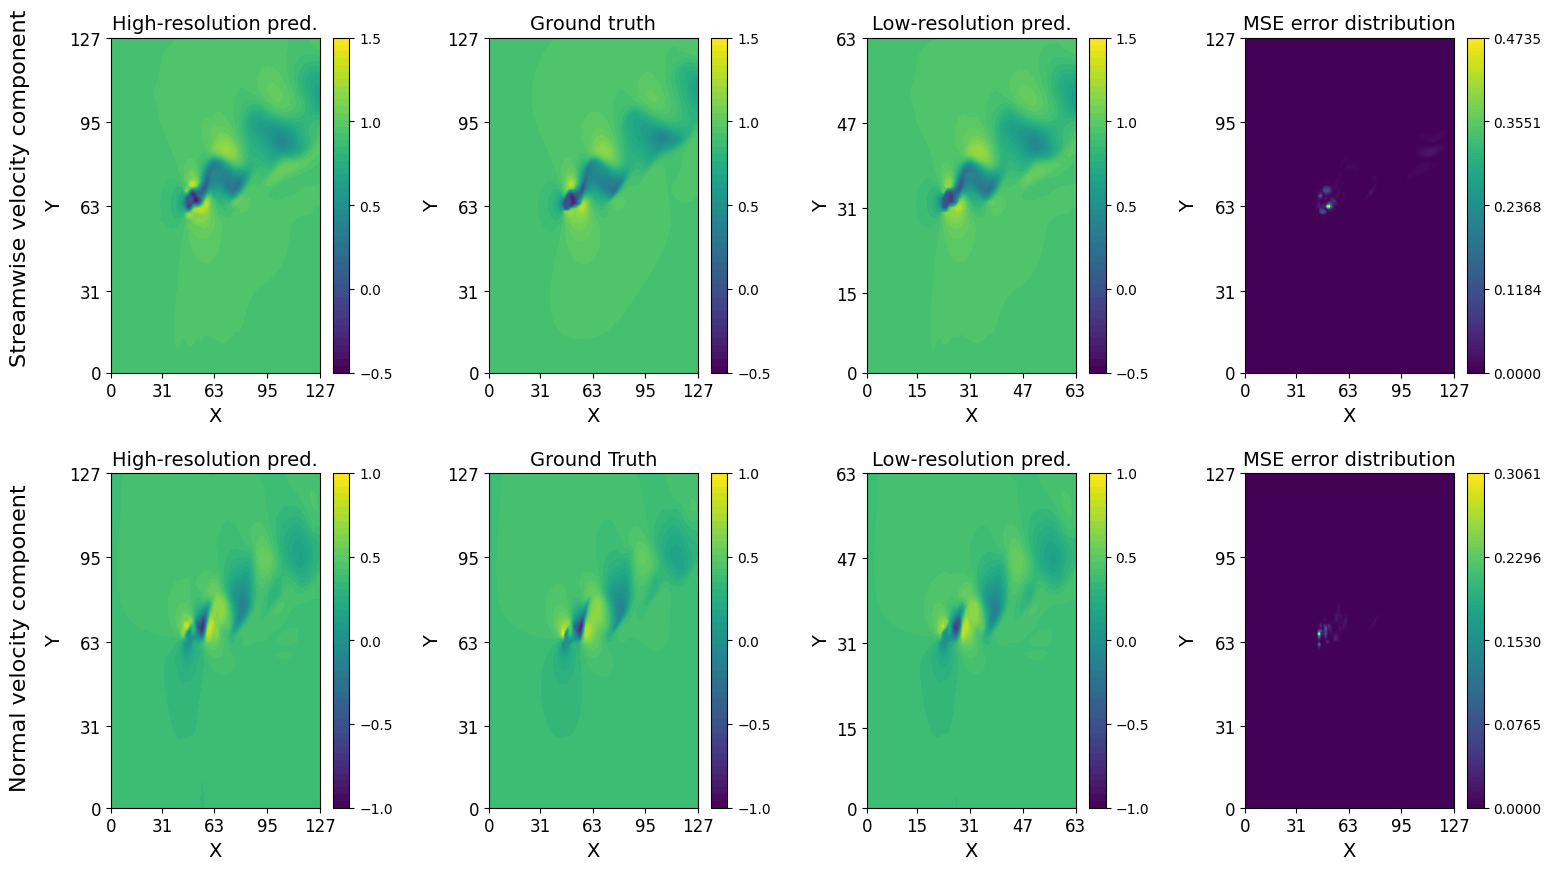

In [34]:
from matplotlib.gridspec import GridSpec

tint = 0
treal = 0

# === Font Size Definitions ===
title_fontsize = 14           # Subplot titles
label_fontsize = 14           # X and Y axis labels
tick_fontsize = 12            # X and Y tick labels
colorbar_tick_fontsize = 10   # Colorbar tick labels
row_label_fontsize = 16       # Row title font size

# === Plot Setup ===
fig = plt.figure(figsize=(18, 10))
gs = GridSpec(2, 4, figure=fig, width_ratios=[1, 1, 1, 1], height_ratios=[1, 1], hspace=0.30, wspace=0.45)

# Color levels
cmin1, cmax1 = -0.5, 1.5
cmin2, cmax2 = -1, 1
levels1 = np.linspace(cmin1, cmax1, 50)
levels2 = np.linspace(cmin2, cmax2, 50)

# Tick setup helper
def set_ticks(ax, data):
    ny, nx = data.shape
    ax.set_xticks(np.linspace(0, nx - 1, 5, dtype=int))
    ax.set_yticks(np.linspace(0, ny - 1, 5, dtype=int))
    ax.tick_params(axis='both', labelsize=tick_fontsize)

# === Row 1 ===
ax1 = fig.add_subplot(gs[0, 0])
contour1 = ax1.contourf(new_tensor[0, :, :, tint], levels=levels1)
ax1.set_title("High-resolution pred.", fontsize=title_fontsize)
ax1.set_xlabel("X", fontsize=label_fontsize)
ax1.set_ylabel("Y", fontsize=label_fontsize)
set_ticks(ax1, new_tensor[0, :, :, tint])
cbar1 = plt.colorbar(contour1, ax=ax1, ticks=np.linspace(cmin1, cmax1, 5))
cbar1.ax.tick_params(labelsize=colorbar_tick_fontsize)

ax2 = fig.add_subplot(gs[0, 1])
contour2 = ax2.contourf(tensorb[0, :, :, treal], levels=levels1)
ax2.set_title("Ground truth", fontsize=title_fontsize)
ax2.set_xlabel("X", fontsize=label_fontsize)
ax2.set_ylabel("Y", fontsize=label_fontsize)
set_ticks(ax2, tensorb[0, :, :, treal])
cbar2 = plt.colorbar(contour2, ax=ax2, ticks=np.linspace(cmin1, cmax1, 5))
cbar2.ax.tick_params(labelsize=colorbar_tick_fontsize)

ax7 = fig.add_subplot(gs[0, 2])
contour7 = ax7.contourf(tensora[0, :, :, treal - 2], levels=levels1)
ax7.set_title("Low-resolution pred.", fontsize=title_fontsize)
ax7.set_xlabel("X", fontsize=label_fontsize)
ax7.set_ylabel("Y", fontsize=label_fontsize)
set_ticks(ax7, tensora[0, :, :, treal - 2])
cbar7 = plt.colorbar(contour7, ax=ax7, ticks=np.linspace(cmin1, cmax1, 5))
cbar7.ax.tick_params(labelsize=colorbar_tick_fontsize)

ax3 = fig.add_subplot(gs[0, 3])
C = (new_tensor[0, :, :, tint] - tensorb[0, :, :, treal])**2
contour3 = ax3.contourf(C, levels=np.linspace(0, np.max(C), 100))
ax3.set_title("MSE error distribution", fontsize=title_fontsize)
ax3.set_xlabel("X", fontsize=label_fontsize)
ax3.set_ylabel("Y", fontsize=label_fontsize)
set_ticks(ax3, C)
cbar3 = plt.colorbar(contour3, ax=ax3, ticks=np.linspace(0, np.max(C), 5))
cbar3.ax.tick_params(labelsize=colorbar_tick_fontsize)

# === Row 2 ===
ax4 = fig.add_subplot(gs[1, 0])
contour4 = ax4.contourf(new_tensor[1, :, :, tint], levels=levels2)
ax4.set_title("High-resolution pred.", fontsize=title_fontsize)
ax4.set_xlabel("X", fontsize=label_fontsize)
ax4.set_ylabel("Y", fontsize=label_fontsize)
set_ticks(ax4, new_tensor[1, :, :, tint])
cbar4 = plt.colorbar(contour4, ax=ax4, ticks=np.linspace(cmin2, cmax2, 5))
cbar4.ax.tick_params(labelsize=colorbar_tick_fontsize)

ax5 = fig.add_subplot(gs[1, 1])
contour5 = ax5.contourf(tensorb[1, :, :, treal], levels=levels2)
ax5.set_title("Ground Truth", fontsize=title_fontsize)
ax5.set_xlabel("X", fontsize=label_fontsize)
ax5.set_ylabel("Y", fontsize=label_fontsize)
set_ticks(ax5, tensorb[1, :, :, treal])
cbar5 = plt.colorbar(contour5, ax=ax5, ticks=np.linspace(cmin2, cmax2, 5))
cbar5.ax.tick_params(labelsize=colorbar_tick_fontsize)

ax8 = fig.add_subplot(gs[1, 2])
contour8 = ax8.contourf(tensora[1, :, :, treal - 2], levels=levels2)
ax8.set_title("Low-resolution pred.", fontsize=title_fontsize)
ax8.set_xlabel("X", fontsize=label_fontsize)
ax8.set_ylabel("Y", fontsize=label_fontsize)
set_ticks(ax8, tensora[1, :, :, treal - 2])
cbar8 = plt.colorbar(contour8, ax=ax8, ticks=np.linspace(cmin2, cmax2, 5))
cbar8.ax.tick_params(labelsize=colorbar_tick_fontsize)

ax6 = fig.add_subplot(gs[1, 3])
C2 = (new_tensor[1, :, :, tint] - tensorb[1, :, :, treal])**2
contour6 = ax6.contourf(C2, levels=np.linspace(0, np.max(C2), 100))
ax6.set_title("MSE error distribution", fontsize=title_fontsize)
ax6.set_xlabel("X", fontsize=label_fontsize)
ax6.set_ylabel("Y", fontsize=label_fontsize)
set_ticks(ax6, C2)
cbar6 = plt.colorbar(contour6, ax=ax6, ticks=np.linspace(0, np.max(C2), 5))
cbar6.ax.tick_params(labelsize=colorbar_tick_fontsize)

# === Row Titles ===
fig.text(0.08, 0.73, "Streamwise velocity component", va='center', ha='right', fontsize=row_label_fontsize, rotation='vertical')
fig.text(0.08, 0.28, "Normal velocity component", va='center', ha='right', fontsize=row_label_fontsize, rotation='vertical')

# Final layout adjustments and show
plt.subplots_adjust(hspace=0.5, wspace=0.4)
plt.show()

### Compute Relative RMSE
Calculates the relative root mean squared error between predicted and ground truth fields to quantify reconstruction accuracy.

In [35]:
reconstruction = new_tensor.copy()
original = tensorb.copy()
primera_componente = original[0,:,:,treal].flatten()
segunda_componente = original[1,:,:,treal].flatten()
primera_componente_r = reconstruction[0, :,:, tint].flatten()
segunda_componente_r = reconstruction[1, :,:, tint].flatten()

len_orig = len(primera_componente)

rmse = np.sqrt(mean_squared_error(primera_componente, primera_componente_r))
value_range = np.max(primera_componente) - np.min(primera_componente)
rrmse = rmse/value_range 

print(f'Relative Root Mean Squared Error (RRMSE): {rrmse}')

rmse = np.sqrt(mean_squared_error(segunda_componente, segunda_componente_r))
value_range = np.max(segunda_componente) - np.min(segunda_componente)
rrmse = rmse/value_range 


print(f'Relative Root Mean Squared Error (RRMSE): {rrmse}')

Relative Root Mean Squared Error (RRMSE): 0.013393513340150442
Relative Root Mean Squared Error (RRMSE): 0.007612499564546759


### Visualize Pointwise Forecast at a Specific Location
Shows both a spatial location on the field and the temporal evolution at that point to assess forecast realism.

(2, 128, 128, 214)


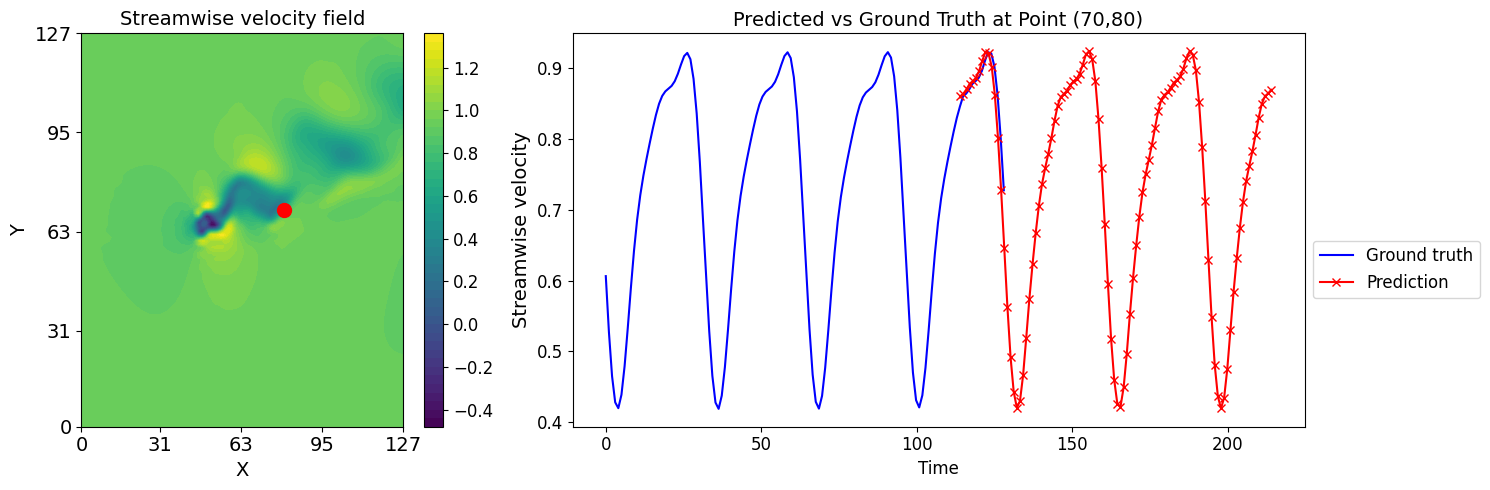

In [36]:
tensorb = tensorb[:,:,:,:]
p1 = 70 # point in X dimension
p2 = 80 # point in Y dimension 
print(new_tensor.shape)
fig, axs = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={'width_ratios': [1.1, 2]})

contour = axs[0].contourf(new_tensor[0, :, :, 0], levels=50)
axs[0].scatter(p2, p1, color='red', s=100, marker='o')  # (x, y) = (col, row)
axs[0].set_title('Streamwise velocity field', fontsize=14)
axs[0].set_xlabel('X', fontsize=14)
axs[0].set_ylabel('Y', fontsize=14)

ny, nx = new_tensor.shape[1:3]
axs[0].set_xticks(np.linspace(0, nx - 1, 5, dtype=int))
axs[0].set_yticks(np.linspace(0, ny - 1, 5, dtype=int))
axs[0].tick_params(axis='both', labelsize=14)

cbar = plt.colorbar(contour, ax=axs[0])
cbar.ax.tick_params(labelsize=12)

axs[1].plot(np.linspace(0, 128, 128), new_tensor[0, p1, p2, 0:128], color='b', label='Ground truth')
axs[1].plot(np.linspace(114, 214, 100), new_tensor[0, p1, p2, 114:214], color='r', marker='x', label='Prediction')

axs[1].set_title(f'Predicted vs Ground Truth at Point ({p1},{p2})', fontsize=14)
axs[1].set_xlabel("Time", fontsize=12)
axs[1].set_ylabel("Streamwise velocity", fontsize=14)
axs[1].tick_params(axis='both', labelsize=12)
axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.4), fontsize=12)

plt.tight_layout()
plt.show()



### Visual inspection of forecasted temporal modes
Plots each predicted temporal mode component over time, comparing the original and forecasted segments. This helps assess prediction consistency across multiple modes.

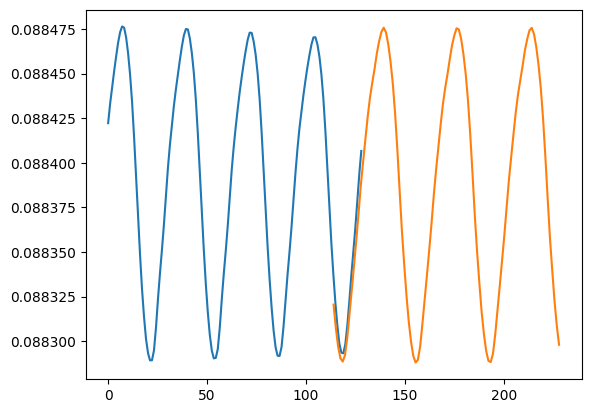

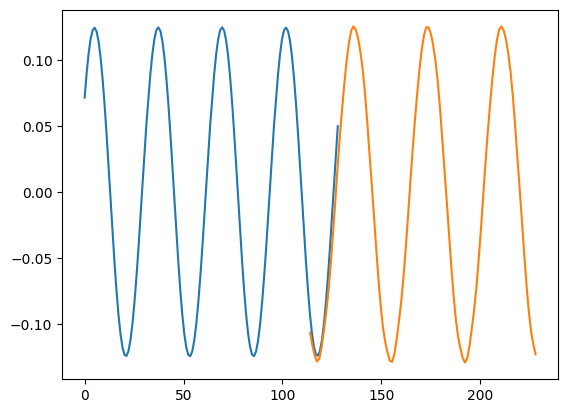

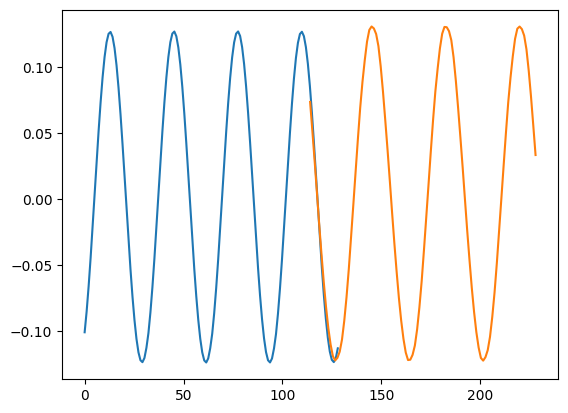

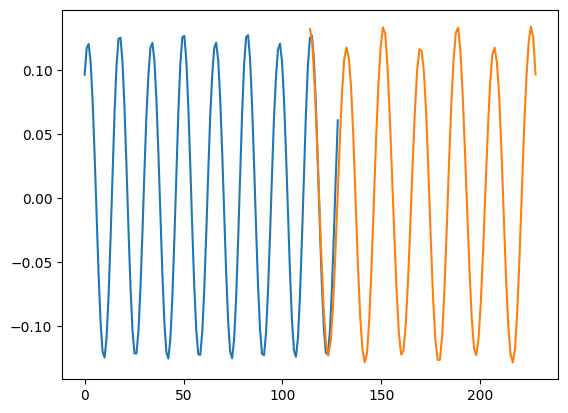

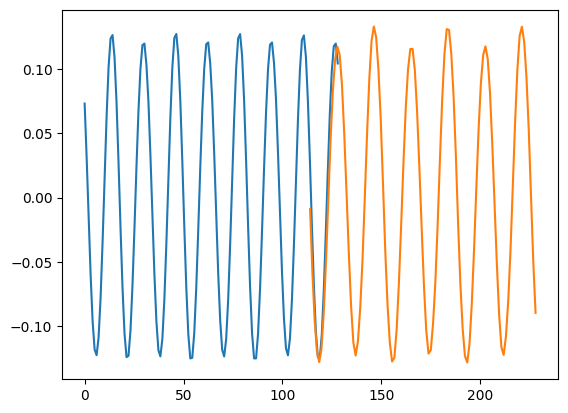

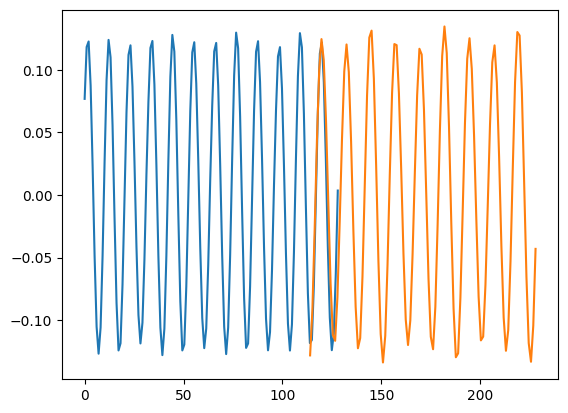

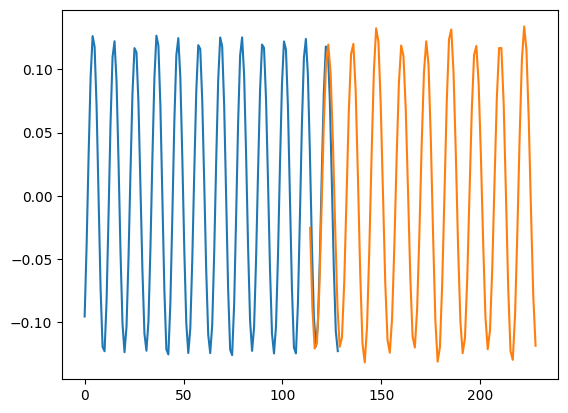

In [37]:
for i in range(7):
    plt.figure()
    plt.plot(np.linspace(0,original_U5.shape[0],original_U5.shape[0]), original_U5[:,i])
    plt.plot(np.linspace(cal_concat,original_U5.shape[0]+over_matrix.shape[0],over_matrix.shape[0]), over_matrix[:,i])
    plt.show()

### Uncertainty quantification and error analysis
Performs statistical analysis on the reconstruction error using normalized residuals. Includes Anderson-Darling tests for normality and histogram-based visualizations of error distributions and spatial patterns.

 Anderson-Darling normality test 

Component U:
  Significance level 15.0%: critical value = 0.5760
  Significance level 10.0%: critical value = 0.6560
  Significance level 5.0%: critical value = 0.7870
  Significance level 2.5%: critical value = 0.9180
  Significance level 1.0%: critical value = 1.0920
  Not normal (reject H0)


Write "s" for Sturges or "r" for Scott-Rice:  s


Number of bins (Sturges) -> 20


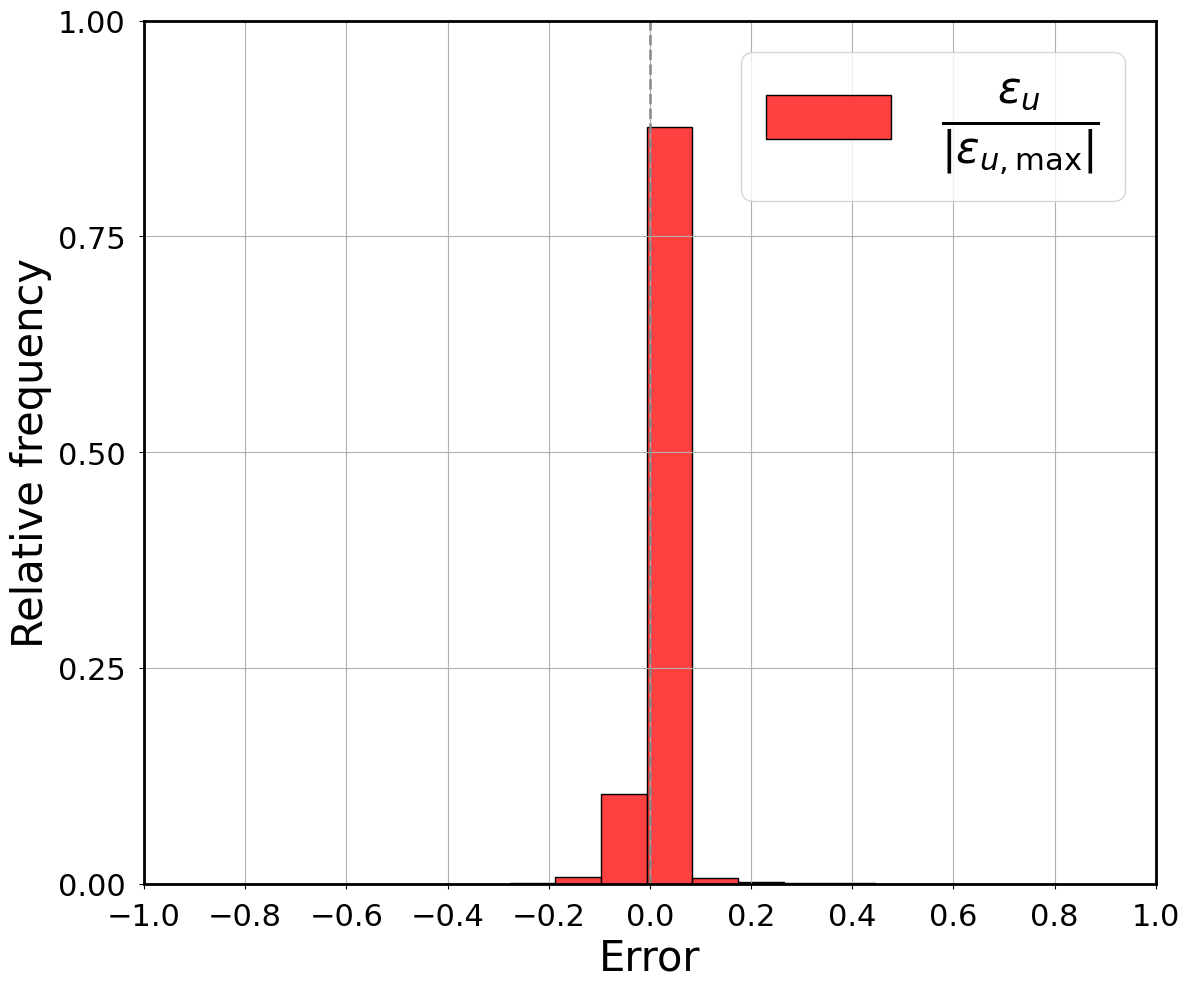


Component V:
  Significance level 15.0%: critical value = 0.5760
  Significance level 10.0%: critical value = 0.6560
  Significance level 5.0%: critical value = 0.7870
  Significance level 2.5%: critical value = 0.9180
  Significance level 1.0%: critical value = 1.0920
  Not normal (reject H0)


Write "s" for Sturges or "r" for Scott-Rice:  s


Number of bins (Sturges) -> 20


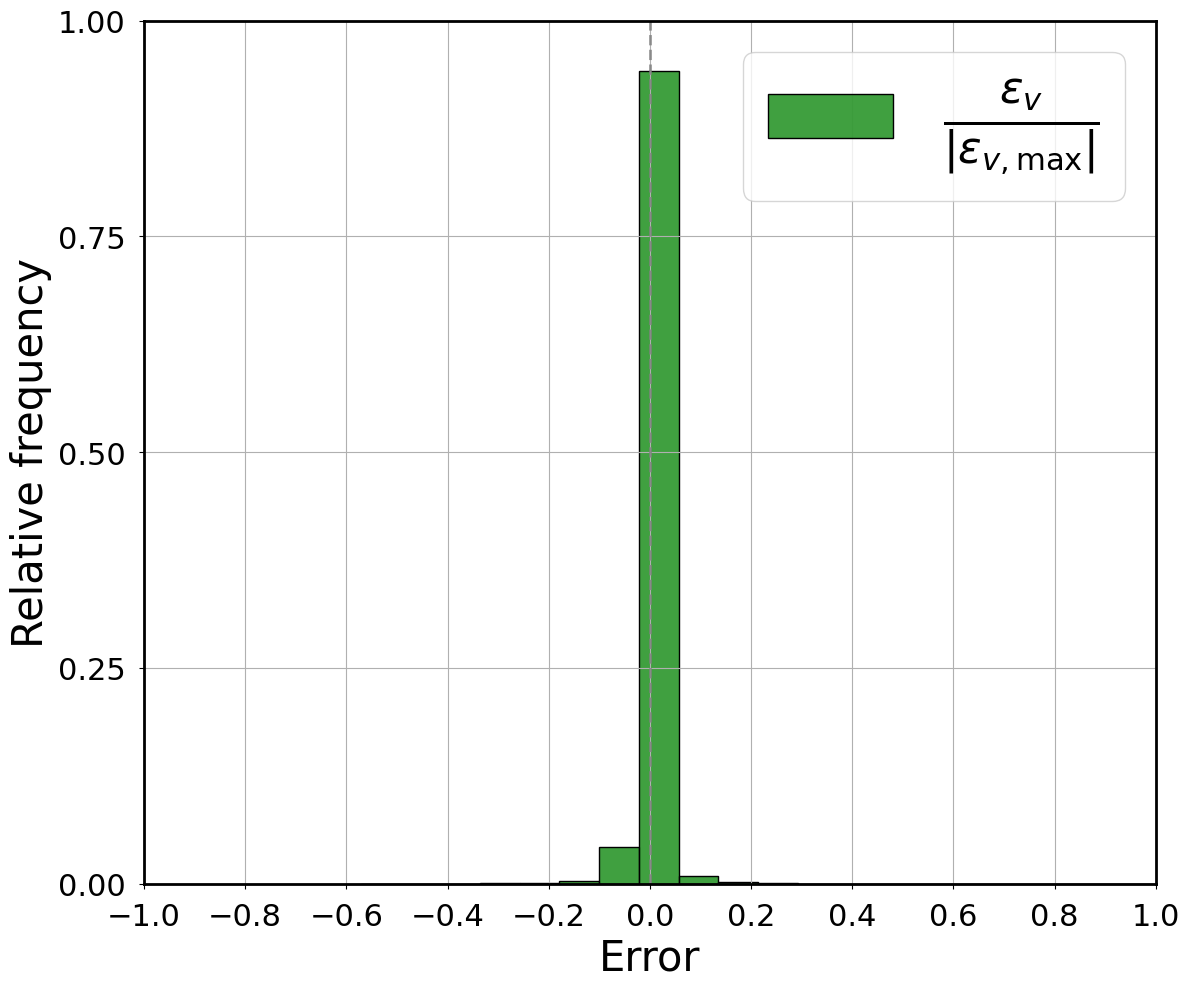

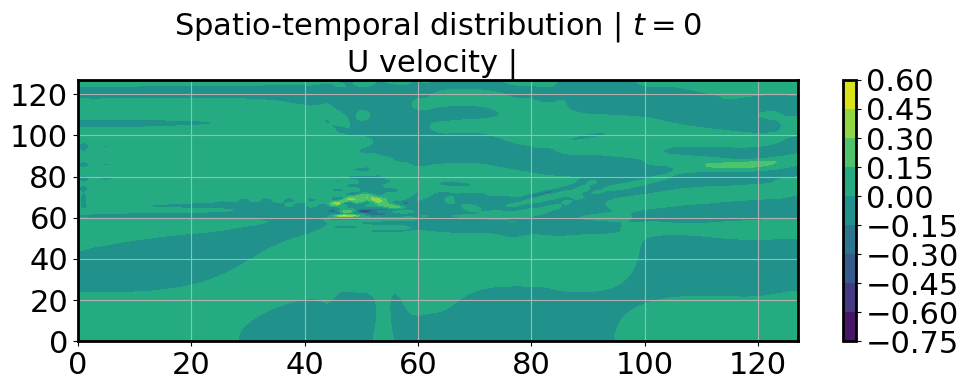

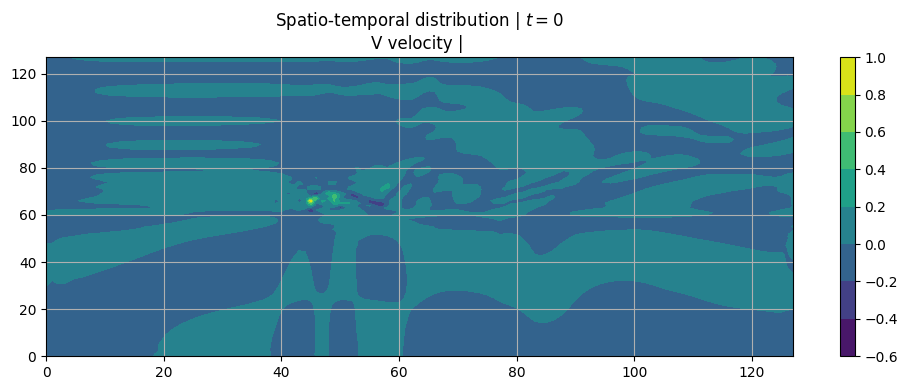

In [38]:
import matplotlib.pyplot as plt 
import seaborn as sns 
import math
from scipy.stats import anderson
from sklearn.metrics import mean_squared_error



Tensor =  tensorb[:2,...]## corresponds to the ground truth data 
Reconst = reconstruction


def UQ(Tensor, Reconst): 
    
    '''
    

    Parameters
    ----------
    Tensor : np.array 
        The ground truth data in tensor form.
    Reconst : np.array
        Is the reconstruction of the original database in tensor form.
    modes : str or int
        If the reconstruction has been obtained through modal decomposition, 
        these are the number of retained modes. 

    Returns
    -------
    One plot of the normalized error relative frequency distribution
    per variable (e.g. velocity component) of the tensor, or, One plot of
    the frequency of the data distribution. 
    
    One contour per variable of the normalized error on each point. 

    '''
    
    # define the font sizes for the plots. 
    plt.rc('axes', labelsize=30)
    plt.rc('axes', titlesize=22)
    plt.rc('legend', fontsize=40)
    plt.rc('figure', titlesize=22)
    plt.rc('xtick', labelsize=22)
    plt.rc('ytick', labelsize=22)
    plt.rc('axes', linewidth=2)
    
    # If the tensor will be standarized by physical variables 
    #(e.g. if you want to use the velocity o pressure change the value)
    Uinf = 1
    Tensor = Tensor / Uinf
    Reconst = Reconst / Uinf
    
    # Calculation of the normalized error
    if Tensor.ndim == 3:
        nv = 1
    else:
        nv = Tensor.shape[0]

    epsU = []
    epsV = []
    epsW = []

    epsU.append(((Tensor[0, ...] - Reconst[0, ...]) / np.abs(Tensor[0, ...] - Reconst[0, ...]).max()))
    epsV.append(((Tensor[1, ...] - Reconst[1, ...]) / np.abs(Tensor[1, ...] - Reconst[1, ...]).max()))
    if Tensor.ndim == 5:
        epsW.append((Tensor[2, ...] - Reconst[2, ...]) / np.abs(Tensor[2, ...] - Reconst[2, ...]).max())


    # To check if the distribution of the error correspond to a normal distribution, the Anderson test 
    # is performed: 
    print(" Anderson-Darling normality test ")
    components = ['U', 'V', 'W']
    # Creation of a list of the normalized errors to iterate over them. 
    eps_raw = [epsU, epsV, epsW]

    for i, eps in enumerate(eps_raw[:nv]):
        flattened = np.array(eps).flatten()
        result = anderson(flattened)
        print(f"\nComponent {components[i]}:")
        
        for level, crit in zip(result.significance_level, result.critical_values):
            print(f"  Significance level {level:.1f}%: critical value = {crit:.4f}")
        if result.statistic < result.critical_values[2]:
            print(" normal ")
        else:
            print("  Not normal (reject H0)")

        bin_custom = input('Write "s" for Sturges or "r" for Scott-Rice: ').strip().lower()
        
        N = flattened.size
        
        if bin_custom == 's':
            # Sturges rule
            bins_custom = math.ceil(np.log2(N) + 1)
            A = 'probability'
            B = 'Relative frequency'
            print(f'Number of bins (Sturges) -> {bins_custom}')
        else:
            # Scott-Rice rule
            sigma = np.std(flattened, ddof=1)
            h = 3.5 * sigma / N**(1/3)
            bins_custom = int(np.ceil((np.max(flattened) - np.min(flattened)) / h))
            A = 'frequency'
            B = 'Frequency'
            print(f'Number of bins (Scott-Rice) -> {bins_custom}')
            
        
        
        fig, ax = plt.subplots(1, 1, figsize=(12, 10))
        sns.histplot(data=flattened, stat=A, bins=bins_custom, legend=True, ax=ax,
                     label=fr'$\frac{{\epsilon_{{{components[i].lower()}}}}}{{|\epsilon_{{{components[i].lower()}, \max}}|}}$', 
                     kde=False, fill=True, common_norm=False, element='bars',
                     color=["red", "green", "blue"][i])
        ax.legend(loc='best', fontsize=45)
        ax.set_xlabel('Error', fontsize=30)
        ax.set_ylabel(B, fontsize=30)
        if bin_custom == 's':
            ax.set_xlim(-1, 1)
            ax.set_ylim(0, 1)
            ax.set_xticks(np.linspace(-1, 1, 11))  
            ax.set_yticks(np.linspace(0, 1, 5))   
            ax.tick_params(axis='both', which='major', pad=10)
        else: 
            ax.set_xlim(-1, 1)
            
        
        

        ax.vlines(0, ymin=0, ymax=1, colors="gray", alpha=0.8, lw=2, linestyles="dashed")
        ax.grid(True)
        plt.tight_layout()
        plt.show()

    
    epslist = [epsU]
    if nv > 1:
        epslist.append(epsV)
        if nv > 2:
            epslist.append(epsW)

    for i in range(nv):
        fig, ax = plt.subplots(1, 1, figsize=(10, 4))

        if Tensor.ndim == 3:
            ax.set_title('Spatio-temporal distribution | ' + r'$t = 0$' + '\n'
                         f'{components[i]} velocity | ')
            im = ax.contourf(epsU[i][0][:][:][..., 0])
            fig.colorbar(im, ax=ax)

        elif Tensor.ndim == 4:
            ax.set_title('Spatio-temporal distribution | ' + r'$t = 0$' + '\n'
                         f'{components[i]} velocity | ')
            im = ax.contourf(epslist[i][0][:][:][..., 0])
            fig.colorbar(im, ax=ax)

        elif Tensor.ndim == 5:
            nz = int(Tensor.shape[3] / 2)
            ax.set_title('Spatio-temporal distribution | ' + r'$t = 0$' +  '\n'
                         f'{components[i]} velocity | XY plane at z = {nz} |')
            im = ax.contourf(epslist[i][..., nz, 0])
            fig.colorbar(im, ax=ax)

        ax.grid(True)
        plt.tight_layout()
        plt.rcdefaults()
        plt.show()

UQ(Tensor[...,100:128], Reconst[...,100:128])
